In [1]:
import numpy as np
import pandas as pd 

# 导入处理分类特征的库
from sklearn.preprocessing import LabelEncoder

# 防止对运行没有影响的报错信息出现
import warnings
warnings.filterwarnings('ignore')

# 导入绘图库
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# 导入训练数据
app_train = pd.read_csv(r'D:\datasheet\Credit_Default_Risk\application_train.csv')
print('Training data shape: ', app_train.shape)

# 导入测试数据
app_test = pd.read_csv(r'D:\datasheet\Credit_Default_Risk\application_test.csv')
print('Testing data shape: ', app_test.shape)

Training data shape:  (307511, 122)
Testing data shape:  (48744, 121)


In [3]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

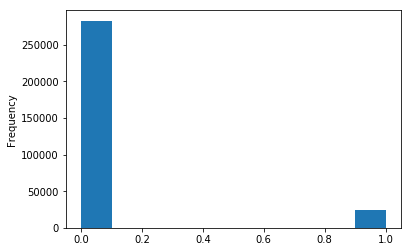

In [4]:
app_train['TARGET'].astype(int).plot.hist()

In [5]:
explore = app_train.describe().T
explore["null"] = app_train.isnull().sum()
explore["Proportion"] = explore["null"]/len(app_train)
explore.loc[explore["null"] != 0,["null","Proportion"]].sort_values('Proportion',ascending=False).head(10)

,null,Proportion
COMMONAREA_MODE,214865,0.698723
COMMONAREA_MEDI,214865,0.698723
COMMONAREA_AVG,214865,0.698723
NONLIVINGAPARTMENTS_MODE,213514,0.694330
NONLIVINGAPARTMENTS_AVG,213514,0.694330
NONLIVINGAPARTMENTS_MEDI,213514,0.694330
LIVINGAPARTMENTS_MEDI,210199,0.683550
LIVINGAPARTMENTS_AVG,210199,0.683550
LIVINGAPARTMENTS_MODE,210199,0.683550
FLOORSMIN_MEDI,208642,0.678486


In [6]:
# 查看每个数据类型的字段个数
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [7]:
#查看每个对象列中分类的个数
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [8]:
# 分类字段规整处理:
#    1、如果分类字段只有两个类别，则用LabelEncoder对其进行分类（0-1）
#    2、如果分类字段中有多个类别，则用one-hot encoding对其进行分类 
#    one-hot encoding是给分类变量中的每个唯一类别创建一个新列

In [9]:
# 创建LabelEncoder对象
le = LabelEncoder()
le_count = 0

# 遍历所有的列
for col in app_train:
    if app_train[col].dtype == 'object':
        # 如果分类字段中的类别数小于等于2
        if len(list(app_train[col].unique())) <= 2:
            # 对训练数据进行训练
            le.fit(app_train[col])
            # 对训练数据和测试数据进行转换
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # 记录LabelEncoder处理字段的个数
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [10]:
# 使用.get_dummies方法对多分类变量进行重新编码（one-hot encoding）
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


In [11]:
# 因为用one-hot encoding进行重新编码会产生新的列，所以需要将训练数据和测试数据进行对齐
train_labels = app_train['TARGET']

# 指定列（axis = 1）进行对齐，而不是行
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# 重新添加目标
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


In [12]:
#观察数据发现DAYS_BIRTH（用户的出生日期）为负值，这是相对于贷款日期来进行计算的【即出生至贷款发生的日期】
app_train['DAYS_BIRTH'].describe()

count    307511.000000
mean     -16036.995067
std        4363.988632
min      -25229.000000
25%      -19682.000000
50%      -15750.000000
75%      -12413.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64

In [13]:
# 将日期间隔除以每年的天数（365天），再按此汇总.可以看出该字段没有异常值
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [14]:
# 观察DAYS_EMPLOYED字段，发现最大值为365243（1000年）出现异常
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

Text(0.5,1,'Days Employment')

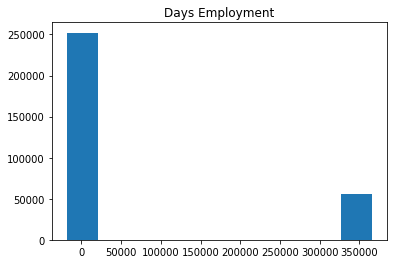

In [15]:
# 绘制DAYS_EMPLOYED数据点分布直方图
plt.hist(app_train['DAYS_EMPLOYED'])
plt.title("Days Employment") 

In [16]:
# 探索DAYS_EMPLOYED异常的人群与非异常人群的违约率情况，发现异常人群的违约率更高【这个发现很重要】
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


In [17]:
# 对于机器学习来说，对于这类对结果有明显影响的异常值，我们会使用特定的值进行替换，
# 以便机器能识别出这个值对结果的影响，在本例中，使用np.nan代替异常值进行计算，然
# 后创建一个新的布尔类型的列来表示该值是否出现异常

Text(0.5,0,'Days Employment')

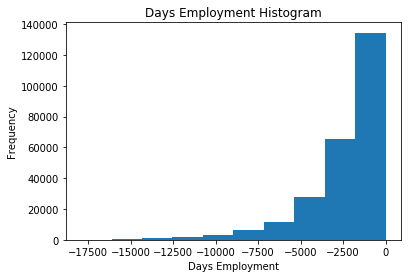

In [18]:
# 创建新的列，用于保存异常值
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# 替换异常值为nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')
plt.xlabel('Days Employment')

In [19]:
# 注意，对训练进行的操作也要在测试数据中进行同样的操作
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


In [20]:
# 将各特征字段与标签字段作相关性（pearson，计算列的成对相关性，不包括NA / null值）
correlations = app_train.corr()['TARGET'].sort_values()

# 显示相关系数
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

Text(0,0.5,'Count')

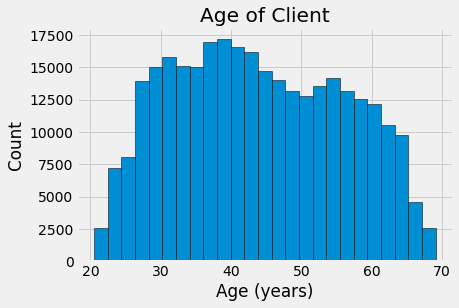

In [21]:
# 源数据中出生日期为负值，而得到的相关系数却是正值，说明这是一个负相关的特征（越老的人，贷款违约率越低）。通过取出生日期的绝对值，可以得到正向的相关系数
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

# 设置绘图风格
plt.style.use('fivethirtyeight')

# 绘制年龄分布
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count')

In [22]:
#从上面的分布直方图只能看出年龄的分布不存在异常值，而需要考察年龄分布与标签的关系，
#则需要借助密度分布曲线（KDE）。下面使用seaborn kdeplot来绘制密度分布曲线

Text(0.5,1,'Distribution of Ages')

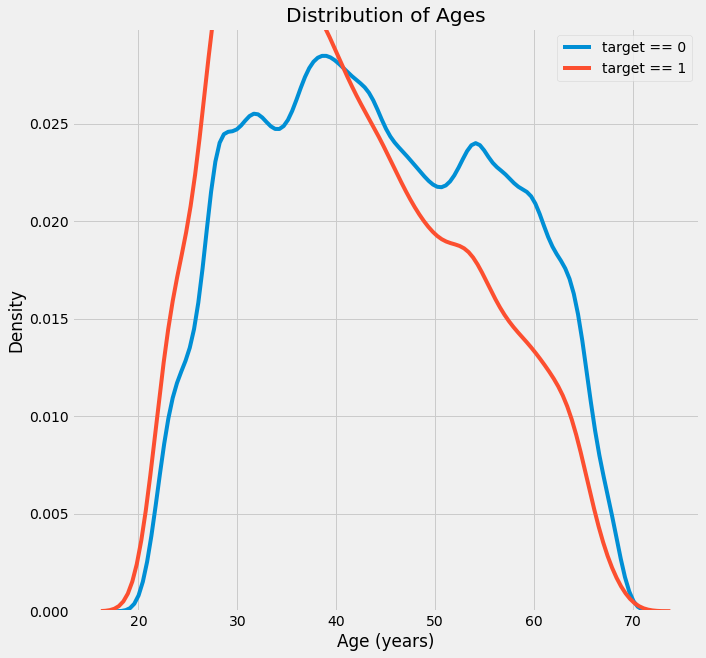

In [23]:
plt.figure(figsize = (10, 10))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.title('Distribution of Ages')

#可以看出target=1曲线更偏向较年轻端

In [24]:
#虽然年龄与标签的相关性很弱，但确实对结果会有影响，接下来对年龄进行分组，查看什么年龄段的人有较高的贷款违约率
# 从训练数据中分离出标签和年龄
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# 将数据按年龄进行分箱，分箱间隔为5
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [25]:
# 按YEARS_BINNED进行聚合，计算平均值
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


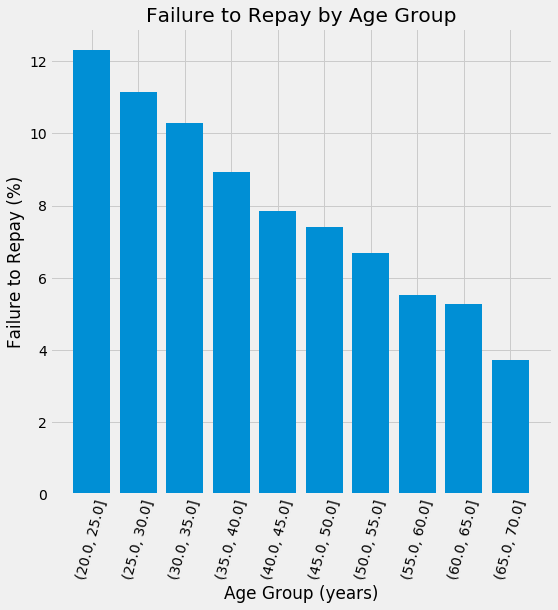

In [26]:
plt.figure(figsize = (8, 8))

# 绘制年龄与违约占比的分布条形图
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

In [27]:
#可以看出明显的趋势：年轻人更有可能不偿还贷款！对于年龄最小的三个年龄组，未偿还的比率高于10％，而对于年龄最大的年龄组，则低于5％。
#这个结论对银行的作用是：因为年轻客户更有可能不偿还贷款，需要在贷款时让他们提供更多的资料审核。

In [28]:
#额外指标：对标签有着负相关的特征EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE_3，数据描述是来自外部的数据，可能是通过其他途径获得的信用评分，
#需要对这些特征进行探索

In [29]:
# 提取变量并计算相关系数
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


Text(0.5,1,'Correlation Heatmap')

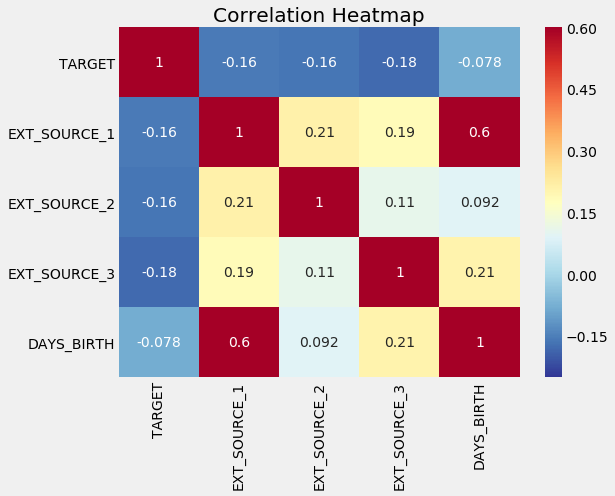

In [30]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap')

In [31]:
#三个EXT_SOURCE特征都与目标具有负相关性，表明随着EXT_SOURCE值的增加，客户更有可能偿还贷款。
#我们还可以看到DAYS_BIRTH与EXT_SOURCE_1正相关（0.6），表明该分数中的一个因素可能是客户年龄。
#接下来按标签区分查看各个EXT_SOURCE特征密度分布曲线

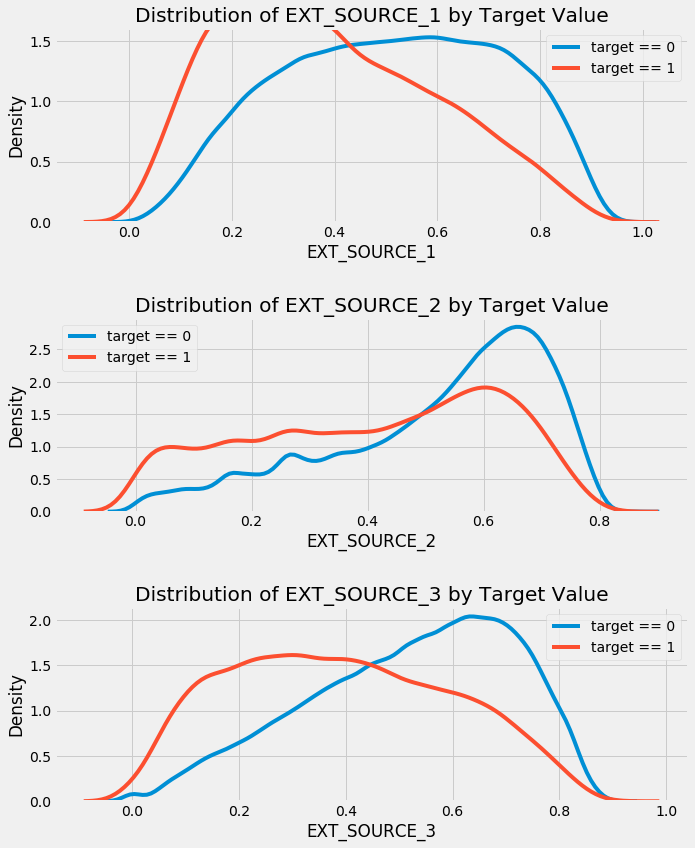

In [32]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source)
    plt.ylabel('Density')
    
plt.tight_layout(h_pad = 2.5)

In [33]:
#从上图可以看出EXT_SOURCE_3对是否违约的区分度最大，虽然从相关系数看来，其相关系数非常弱，但仍然可以对结果进行预测

In [34]:
#Pairs Plot是一个很好的探索工具，因为它可以让我们看到多对变量之间的关系以及单个变量的分布。可以通过seaborn可视化库中的PairGrid函数进行绘制

Text(0.5,1.05,'Ext Source and Age Features Pairs Plot')

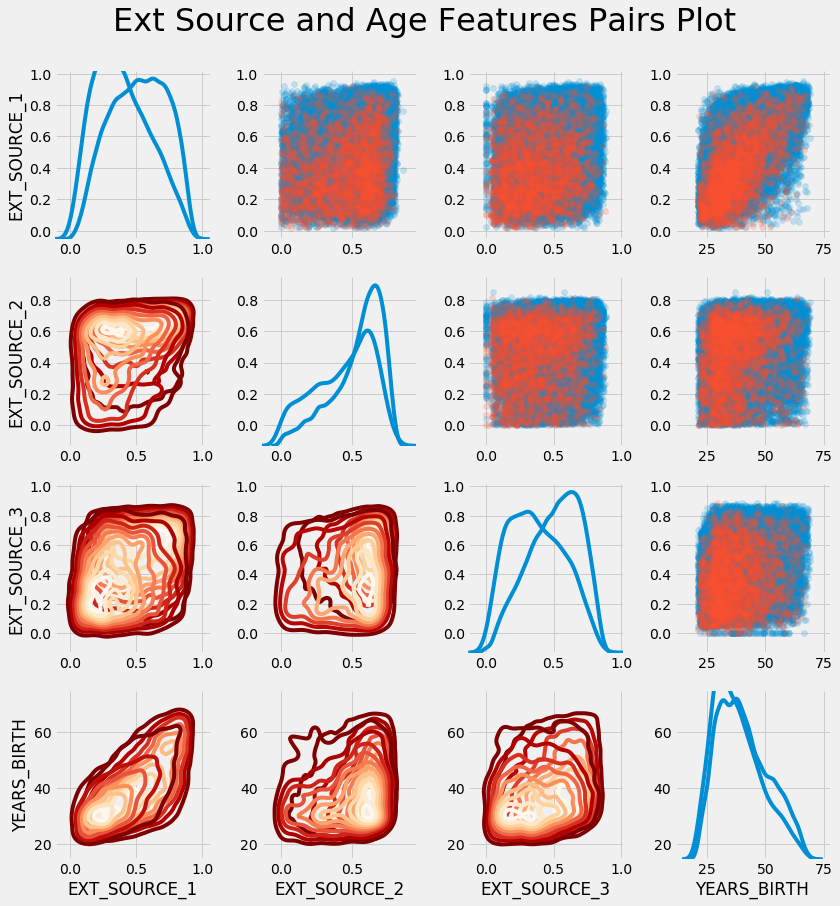

In [35]:
# 复制绘图数据
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# 加入客户年龄
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# 删除空值并将数据限制在前100000行
plot_data = plot_data.dropna().loc[:100000, :]

# 定义函数用于计算两个变量间的相关系数
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# 创建pairgrid对象
grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# 将左对角线以上的图形绘制为散点图
grid.map_upper(plt.scatter, alpha = 0.2)

# 对角线的图形绘制为密度分布曲线
grid.map_diag(sns.kdeplot)

# 将左对角线以下的图形绘制为密度图（cmap = plt.cm.OrRd_r是绘图样式，等高线图）
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r)

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05)

In [36]:
# 特征工程1：常见的特征变换方法有基于多项式的、基于指数函数的、基于对数函数的,以下介绍基于多项式的变量变换方法
# 参阅http://www.cnblogs.com/jasonfreak/p/5448385.html

In [37]:
# 多项式变换方法，比如构造变量 EXT_SOURCE_1^2 及 EXT_SOURCE_2^2 或 EXT_SOURCE_1 * EXT_SOURCE_2等，下面的使用EXT_SOURCE和DAYS_BIRTH来进行多项式构造

In [38]:
# 使用Scikit-Learn中的 PolynomialFeatures类来进行多项式变换，参数degree默认为2，本算法中设置为3
# 参阅https://blog.csdn.net/LULEI1217/article/details/49582821
# 构造一个新的dataframe用于变量变换
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# 使用preproccessing库的Imputer类对数据进行缺失值计算，Imputer可以对缺失值进行批量填充
# Imputer使用方法参阅http://sklearn.apachecn.org/cn/0.19.0/modules/preprocessing.html
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy = 'median')
poly_target = poly_features['TARGET']
poly_features = poly_features.drop(columns = ['TARGET'])

# 估计缺失值
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# 创建degree = 3 的多项式特征对象
poly_transformer = PolynomialFeatures(degree = 3)

# 训练特征
poly_transformer.fit(poly_features)

# 特征转换
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)

print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


In [39]:
# 从结果可以看出多项式转换得到了大量的特征值，使用get_feature_names方法可以得到各特征值的名称
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

In [40]:
# 现在就可以查看所创建的特征值是否与结果存在相关性
# 构造一个包含特征值的dataframe
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# 增加目标值
poly_features['TARGET'] = poly_target

# 探索变量与目标值的相关关系
poly_corrs = poly_features.corr()['TARGET'].sort_values()

print(poly_corrs.head(10))
print(poly_corrs.tail(5))
#从结果可以看出部分构造特征值比原特征值与结果有更强相关性

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


In [41]:
# 检验所构造的特征值是否有效，做法是将特征值放回到训练集和测试集中运行，观察特征值加入前后的变化
# 构造测试数据集的特征dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# 将特征值匹配到训练数据中
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# 将特征值匹配到测试数据集中
poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# 数据对齐
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

# 输出新数据集的大小
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

Training data with polynomial features shape:  (307511, 275)
Testing data with polynomial features shape:   (48744, 275)


In [42]:
# 特征工程2：通过业务领域的知识来创建特征值，根据金融领域知识，构造以下特征值：
'''
CREDIT_INCOME_PERCENT: 信贷总额-收入百分比，信贷总额相对于客户收入的百分比
ANNUITY_INCOME_PERCENT: 信贷年金-收入百分比，信贷年金相对于客户收入的百分比
CREDIT_TERM: 信贷期限，以月为单位的付款期限
DAYS_EMPLOYED_PERCENT: 就业天数相对于客户年龄的百分比
'''

'\nCREDIT_INCOME_PERCENT: 信贷总额-收入百分比，信贷总额相对于客户收入的百分比\nANNUITY_INCOME_PERCENT: 信贷年金-收入百分比，信贷年金相对于客户收入的百分比\nCREDIT_TERM: 信贷期限，以月为单位的付款期限\nDAYS_EMPLOYED_PERCENT: 就业天数相对于客户年龄的百分比\n'

In [43]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

In [44]:
# 对各领域特征值进行图表可视化，使用taget值对各特征值的密度分布制作KDE曲线

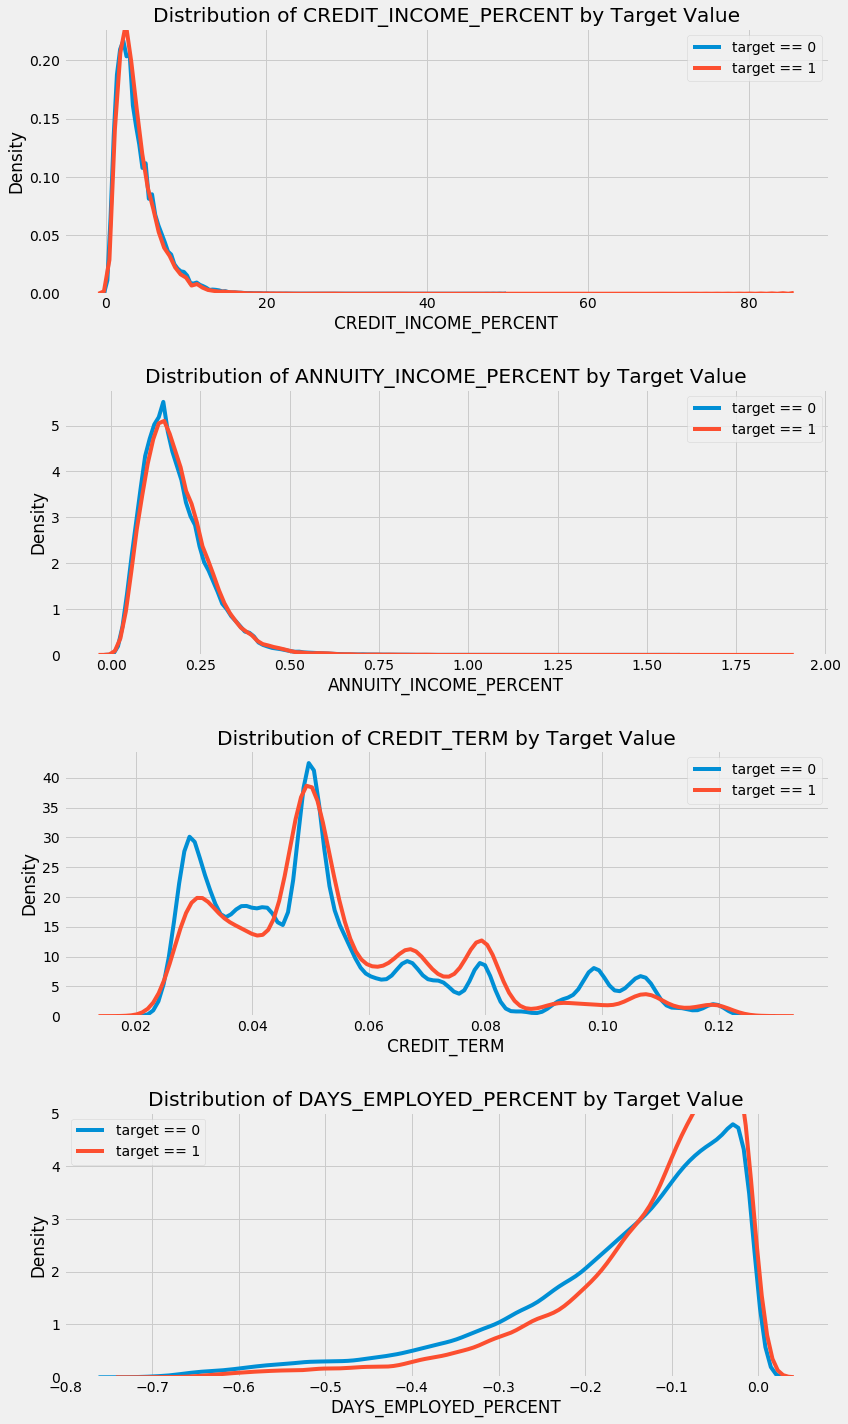

In [45]:
plt.figure(figsize = (12, 20))
# 遍历新特征变量
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # 创建子图
    plt.subplot(4, 1, i + 1)
    # 绘制无违约记录的数据
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # 绘制违约记录的数据
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')

    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)
# 很难看出新构造的特征对结果有什么影响

In [46]:
# 使用模型预测结果之前，首先要对特征值进行缺失值填充和标准化
# 为了分析特征工程构造出来的特征值是否有明显作用，这里先对已经做过数据预处理(分类变量哑编码，异常值处理)的源数据train和test进行模型拟合并预测结果

In [47]:
from sklearn.preprocessing import MinMaxScaler, Imputer

# 从训练集中删除标签值
if 'TARGET' in app_train:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()
    
# 特征字段名
features = list(train.columns)

# 复制测试值
test = app_test.copy()

# 使用中位数替换缺失值
imputer = Imputer(strategy = 'median')

# 0-1规范化
scaler = MinMaxScaler(feature_range = (0, 1))

# 拟合训练数据
imputer.fit(train)

# 转换训练集和测试集
train = imputer.transform(train)
test = imputer.transform(app_test)

# 对训练集和测试集进行0-1规范化
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 240)
Testing data shape:  (48744, 240)


In [48]:
# 模型1：逻辑回归模型
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(C = 0.0001)
# c：正则化系数λ的倒数，float类型，默认为1.0。必须是正浮点型数。像SVM一样，越小的数值表示越强的正则化。
# 参数内容参阅：http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.decision_function%20%E9%80%BB%E8%BE%91%E5%9B%9E%E5%BD%92

# Train on the training data
log_reg.fit(train, train_labels)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [49]:
# 预测结果
# 预测结果中的第一列是准时还贷的概率，第二列是违约的概率，我们要预测的是违约的概率，故返回第二列的内容[:,1]
log_reg_pred = log_reg.predict_proba(test)[:, 1]

In [50]:
# 生成数据文件
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

submit.head()

,SK_ID_CURR,TARGET
0,100001,0.087750
1,100005,0.163957
2,100013,0.110238
3,100028,0.076575
4,100038,0.154924


In [51]:
# 保存数据文件
submit.to_csv('log_reg_baseline.csv', index = False)

In [52]:
# 逻辑回归预测的结果是介于0-1的概率值，可以通过设定违约判定的概率值来判断用户是否可能违约

In [53]:
# 模型1：增强模型—随机森林
# 通过设置很多颗树构造的随机森林可以提高预测的准确性，这里设置100颗树进行预测

In [54]:
from sklearn.ensemble import RandomForestClassifier

# 设定参数
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

In [55]:
# 拟合训练集
random_forest.fit(train, train_labels)

# 输出各特征值对预测结果的重要性
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# 对测试集进行预测
predictions = random_forest.predict_proba(test)[:, 1]

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   57.0s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished


In [56]:
# 注意：predict_proba是给出每个预测标签的概率值，这里是二分类问题，故有1和0两种结果，我们需要预测的是违约概率【predict会直接给出预测值而不是概率】

In [57]:
# 生成数据文件
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions
submit.head()

,SK_ID_CURR,TARGET
0,100001,0.13
1,100005,0.21
2,100013,0.05
3,100028,0.14
4,100038,0.19


In [58]:
# 保存数据文件
submit.to_csv('random_forest_baseline.csv', index = False)

In [59]:
# 利用工程特征进行预测

In [60]:
poly_features_names = list(app_train_poly.columns)

imputer = Imputer(strategy = 'median')

poly_features = imputer.fit_transform(app_train_poly)
poly_features_test = imputer.transform(app_test_poly)

# 0-1规范化
scaler = MinMaxScaler(feature_range = (0, 1))

poly_features = scaler.fit_transform(poly_features)
poly_features_test = scaler.transform(poly_features_test)

random_forest_poly = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

In [61]:
# Train on the training data
random_forest_poly.fit(poly_features, train_labels)

# Make predictions on the test data
predictions = random_forest_poly.predict_proba(poly_features_test)[:, 1]

# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline_engineered.csv', index = False)

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


In [62]:
# 利用专业知识创建的特征字段进行预测

In [63]:
app_train_domain = app_train_domain.drop(columns = 'TARGET')

domain_features_names = list(app_train_domain.columns)

# 中位数填充专业领域特征的缺失值
imputer = Imputer(strategy = 'median')

domain_features = imputer.fit_transform(app_train_domain)
domain_features_test = imputer.transform(app_test_domain)

# 数值0-1规范化
scaler = MinMaxScaler(feature_range = (0, 1))

domain_features = scaler.fit_transform(domain_features)
domain_features_test = scaler.transform(domain_features_test)

random_forest_domain = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

# 拟合训练集
random_forest_domain.fit(domain_features, train_labels)

# 计算因素占比
feature_importance_values_domain = random_forest_domain.feature_importances_
feature_importances_domain = pd.DataFrame({'feature': domain_features_names, 'importance': feature_importance_values_domain})

# 对测试集进行预测
predictions = random_forest_domain.predict_proba(domain_features_test)[:, 1]

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished


In [64]:
# 生成数据文件
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

In [65]:
# 保存
submit.to_csv('random_forest_baseline_domain.csv', index = False)

In [66]:
# 特征解释，特征重要性

In [67]:
def plot_feature_importances(df):
    """  
    参数:
        df (dataframe): 包含名为feature的特征值与重要性importance
        
    """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

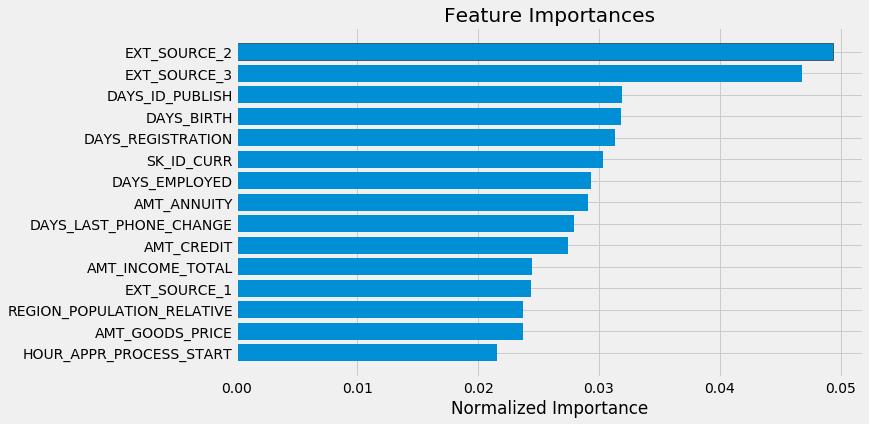

In [68]:
# 展示初始特征对结果影响的重要性
# 通过查看各特征值对结果影响的重要性，可以知道哪些因素对模型判断具有较大影响（同时也可以在保证性能不下降的同时删除一些影响不大的特征值）
feature_importances_sorted = plot_feature_importances(feature_importances)

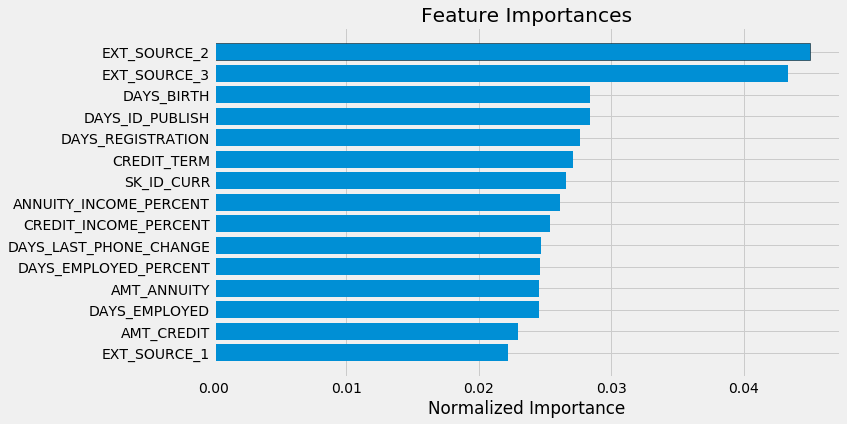

In [69]:
# 加入领域特征，查看影响排名top15的特征值，可以发现有四个领域特征值进入top15名单
feature_importances_domain_sorted = plot_feature_importances(feature_importances_domain)

In [70]:
# LightGBM 提出的主要原因就是为了解决 GBDT 在海量数据遇到的问题，LightGBM具有更快的训练速度（支持分布式运算）、更低的内存消耗、更好的准确率

In [71]:
# Light Gradient Boosting Machine【轻量梯度增强模型】
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb   # pip install lightgbm
import gc

def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """使用交叉验证训练和测试LightGBM模型
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # 建立交叉验证对象
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [72]:
submission, fi, metrics = model(app_train, app_test)
print('Baseline metrics')
print(metrics)

Training Data Shape:  (307511, 239)
Testing Data Shape:  (48744, 239)
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.754949	train's auc: 0.79887
Early stopping, best iteration is:
[208]	valid's auc: 0.755109	train's auc: 0.80025
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.758539	train's auc: 0.798518
Early stopping, best iteration is:
[217]	valid's auc: 0.758619	train's auc: 0.801374
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.762652	train's auc: 0.79774
[400]	valid's auc: 0.762202	train's auc: 0.827288
Early stopping, best iteration is:
[320]	valid's auc: 0.763103	train's auc: 0.81638
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.757496	train's auc: 0.799107
Early stopping, best iteration is:
[183]	valid's auc: 0.75759	train's auc: 0.796125
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.758099	tr

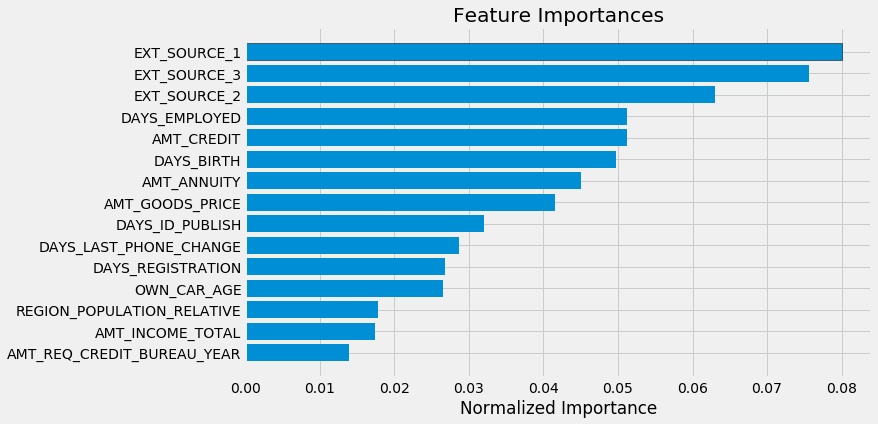

In [73]:
fi_sorted = plot_feature_importances(fi)

In [74]:
submission.to_csv('baseline_lgb.csv', index = False)

In [75]:
app_train_domain['TARGET'] = train_labels

# Test the domain knolwedge features
submission_domain, fi_domain, metrics_domain = model(app_train_domain, app_test_domain)
print('Baseline with domain knowledge features metrics')
print(metrics_domain)

Training Data Shape:  (307511, 243)
Testing Data Shape:  (48744, 243)
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.762577	train's auc: 0.804531
Early stopping, best iteration is:
[237]	valid's auc: 0.762858	train's auc: 0.810671
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.765594	train's auc: 0.804304
Early stopping, best iteration is:
[227]	valid's auc: 0.765861	train's auc: 0.808665
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.770139	train's auc: 0.803753
[400]	valid's auc: 0.770328	train's auc: 0.834338
Early stopping, best iteration is:
[302]	valid's auc: 0.770629	train's auc: 0.820401
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.765653	train's auc: 0.804487
Early stopping, best iteration is:
[262]	valid's auc: 0.766318	train's auc: 0.815066
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.7644

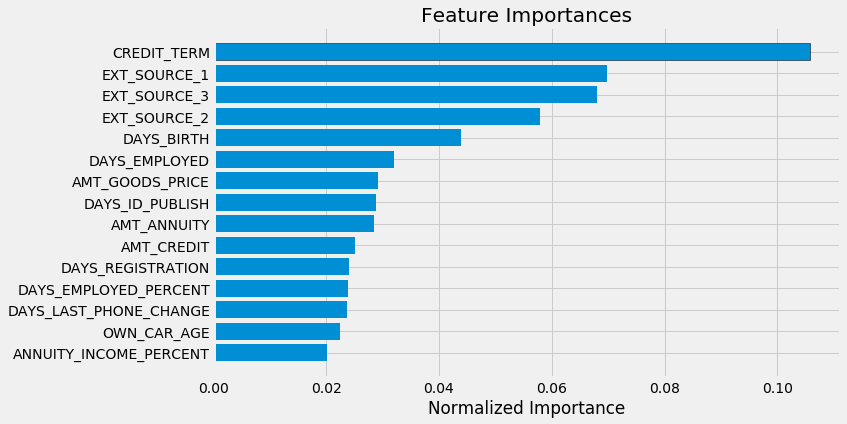

In [76]:
fi_sorted = plot_feature_importances(fi_domain)

In [77]:
submission_domain.to_csv('baseline_lgb_domain_features.csv', index = False)